In [133]:
import os
import argparse
from glob import glob
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import wandb

import jax
import jax.numpy as jnp

import torch
import torchvision.transforms as transforms
import tensorflow as tf
import tensorflow_datasets as tfds

In [134]:
class GANDataset(torch.utils.data.Dataset):
    def __init__(self, args):
        self.args = args

        self.paths_a = glob('./data/trainA/*.jpg')
        self.paths_b = glob('./data/trainB/*.jpg')

        self.imgs_a = np.zeros(
            (len(self.paths_a), 32, 32, 3), dtype=np.float32)
        for i, path in tqdm(enumerate(self.paths_a)):
            img = np.asarray(Image.open(path)) / 255.0
            img = cv2.resize(img, dsize=(
                32, 32), interpolation=cv2.INTER_CUBIC).reshape(1, 32, 32, 3)
            self.imgs_a[i] = img

        self.imgs_b = np.zeros(
            (len(self.paths_b), 32, 32, 3), dtype=np.float32)
        for i, path in tqdm(enumerate(self.paths_b)):
            img = np.asarray(Image.open(path)) / 255.0
            img = cv2.resize(img, dsize=(
                32, 32), interpolation=cv2.INTER_CUBIC).reshape(1, 32, 32, 3)
            self.imgs_b[i] = img

        self.transforms = transforms.Compose([
            # transforms.ToTensor(),
            # transforms.ToPILImage(),
            # transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(hue=0.15),
            # transforms.RandomGrayscale(p=0.25),
            # transforms.RandomRotation(35),
            # transforms.RandomPerspective(distortion_scale=0.35),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return len(self.paths_a)

    def __getitem__(self, index):
        img_a = self.imgs_a[index]
        img_b = self.imgs_b[index]

        img_a = self.transforms(img_a).numpy().transpose(1, 2, 0)
        img_b = self.transforms(img_b).numpy().transpose(1, 2, 0)
        # img_a = img_a.transpose(1, 2, 0)
        # img_b = img_b.transpose(1, 2, 0)

        return img_a, img_b

In [117]:
def shard(xs):
    return jax.tree_map(
        lambda x: x.reshape((jax.device_count(), -1) + x.shape[1:]), xs)

In [118]:
import flax
from flax import linen as nn

In [119]:
class Generator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, z):
        x = nn.ConvTranspose(features=64*8, kernel_size=(4, 4), strides=(1, 1), padding='VALID', use_bias=False)(z)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64*4, kernel_size=(4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64*2, kernel_size=(4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=64, kernel_size=(4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=3, kernel_size=(4, 4), strides=(1, 1), padding='SAME', use_bias=False)(x)
        return jnp.tanh(x)

In [120]:
class Discriminator(nn.Module):
    training:bool

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=64, kernel_size=(
            4, 4), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*2, kernel_size=(4, 4),
                         strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*4, kernel_size=(4, 4),
                         strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=64*8, kernel_size=(4, 4),
                         strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not self.training, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        x = nn.Conv(features=1, kernel_size=(
            1, 1), strides=(4, 4), padding='VALID', use_bias=False)(x)
        x = jnp.reshape(x, [x.shape[0], -1])

        return x

In [121]:
@jax.vmap
def bce_logits_loss(logit, label):
    return jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(-jnp.abs(logit)))


def loss_g(params_g, params_d, batch, rng, variables_g, variables_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    fake_batch, variables_g = Generator(training=True).apply({'params': params_g, 'batch_stats': variables_g['batch_stats']}, z, mutable=['batch_stats'])

    fake_logits, variables_d = Discriminator(training=True).apply({'params': params_d, 'batch_stats': variables_d['batch_stats']}, fake_batch, mutable=['batch_stats'])

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    return jnp.mean(bce_logits_loss(fake_logits, real_labels)), (variables_g, variables_d)


def loss_d(params_d, params_g, batch, rng, variables_g, variables_d):
    z = jax.random.normal(rng, shape=(batch.shape[0], 1, 1, 100))

    fake_batch, variables_g = Generator(training=True).apply({'params': params_g, 'batch_stats': variables_g['batch_stats']}, z, mutable=['batch_stats'])

    real_logits, variables_d = Discriminator(training=True).apply({'params': params_d, 'batch_stats': variables_d['batch_stats']}, batch, mutable=['batch_stats'])
    fake_logits, variables_d = Discriminator(training=True).apply({'params': params_d, 'batch_stats': variables_d['batch_stats']}, fake_batch, mutable=['batch_stats'])

    real_labels = jnp.ones((batch.shape[0],), dtype=jnp.int32)
    real_loss = bce_logits_loss(real_logits, real_labels)

    fake_labels = jnp.zeros((batch.shape[0],), dtype=jnp.int32)
    fake_loss = bce_logits_loss(fake_logits, fake_labels)

    return jnp.mean(real_loss + fake_loss), (variables_g, variables_d)


@partial(jax.pmap, axis_name='batch')
def train_step(rng, variables_g, variables_d, optimizer_g, optimizer_d, batch):
    rng, rng_g, rng_d = jax.random.split(rng, 3)

    (g_loss, (variables_g, variables_d)), grad_g = jax.value_and_grad(loss_g, has_aux=True)(
        optimizer_g.target, optimizer_d.target, batch, rng_g, variables_g, variables_d)
    g_loss = jax.lax.pmean(g_loss, axis_name='batch')
    grad_g = jax.lax.pmean(grad_g, axis_name='batch')

    optimizer_g = optimizer_g.apply_gradient(grad_g)

    (d_loss, (variables_g, variables_d)), grad_d = jax.value_and_grad(loss_d, has_aux=True)(
        optimizer_d.target, optimizer_g.target, batch, rng_d, variables_g, variables_d)

    d_loss = jax.lax.pmean(d_loss, axis_name='batch')
    grad_d = jax.lax.pmean(grad_d, axis_name='batch')

    optimizer_d = optimizer_d.apply_gradient(grad_d)

    return rng, variables_g, variables_d, optimizer_g, optimizer_d, d_loss, g_loss

In [135]:
dataset = GANDataset({})
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True)

3400it [00:08, 414.23it/s]
3400it [00:11, 283.77it/s]


In [136]:
img_a, img_b = dataset[0]

In [138]:
img_a.shape

(32, 32, 3)

In [140]:
img_a.mean(), img_a.std(), img_a.min(), img_a.max()

(-0.05453224, 0.5143888, -1.0093443, 0.948223)

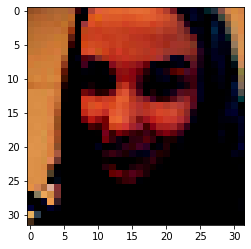

In [139]:
plt.imshow(img_a)

In [141]:
def make_dataset(batch_size, seed=1):
    mnist = tfds.load("mnist")

    def _preprocess(sample):
        image = tf.image.convert_image_dtype(sample["image"], tf.float32)
        image = tf.image.resize(image, (32, 32))
        return 2.0 * image - 1.0

    ds = mnist["train"]
    ds = ds.map(map_func=_preprocess,
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
    return iter(tfds.as_numpy(ds))

In [142]:
dataset = make_dataset(batch_size=2)

In [143]:
batch = next(dataset)

In [145]:
batch[0].shape

(32, 32, 1)

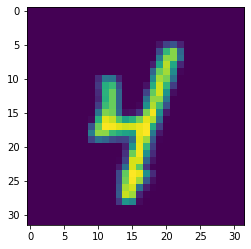

In [146]:
plt.imshow(batch[0].reshape(32, 32))

In [147]:
batch[0].mean(), batch[0].std(), batch[0].min(), batch[0].max()

(-0.8358818, 0.45208228, -1.0, 0.98431385)

In [130]:
rng = jax.random.PRNGKey(42)
rng, rng_g, rng_d = jax.random.split(rng, 3)

init_batch_g = jnp.ones((1, 1, 1, 100), jnp.float32)
variables_g = Generator(training=True).init(rng_g, init_batch_g)

init_batch_d = jnp.ones((1, 32, 32, 3), jnp.float32)
variables_d = Discriminator(training=True).init(rng_d, init_batch_d)

optimizer_g = flax.optim.Adam(
    learning_rate=1e-4, beta1=0.5, beta2=0.9).create(variables_g["params"])
optimizer_g = flax.jax_utils.replicate(optimizer_g)

optimizer_d = flax.optim.Adam(
    learning_rate=1e-4, beta1=0.5, beta2=0.9).create(variables_d["params"])
optimizer_d = flax.jax_utils.replicate(optimizer_d)

variables_g = flax.jax_utils.replicate(variables_g)
variables_d = flax.jax_utils.replicate(variables_d)

rngs = jax.random.split(rng, num=jax.local_device_count())

0it [00:00, ?it/s]

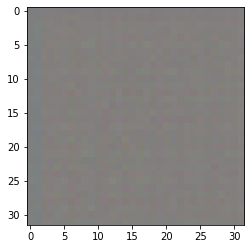

0it [00:30, ?it/s]
0it [00:00, ?it/s]

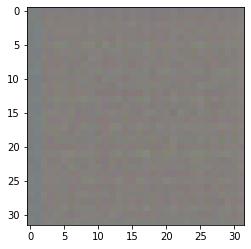

0it [00:00, ?it/s]
0it [00:00, ?it/s]

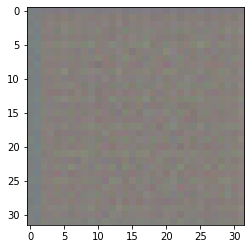

0it [00:00, ?it/s]
0it [00:00, ?it/s]

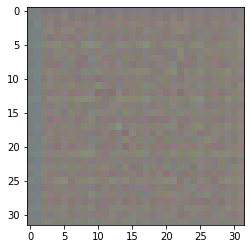

0it [00:00, ?it/s]
0it [00:00, ?it/s]

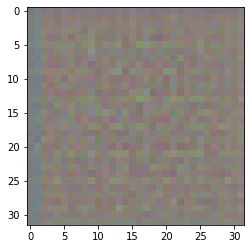

0it [00:00, ?it/s]
0it [00:00, ?it/s]

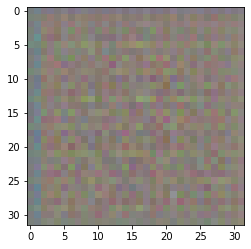

0it [00:00, ?it/s]
0it [00:00, ?it/s]

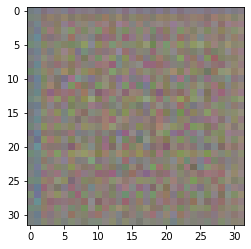

0it [00:00, ?it/s]
0it [00:00, ?it/s]

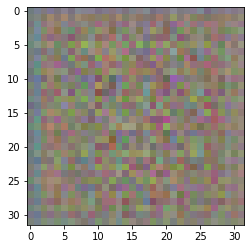

0it [00:00, ?it/s]
0it [00:00, ?it/s]

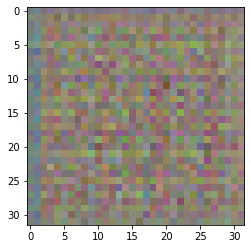

0it [00:00, ?it/s]
0it [00:00, ?it/s]

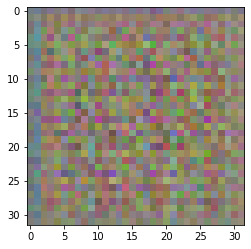

0it [00:00, ?it/s]
0it [00:00, ?it/s]

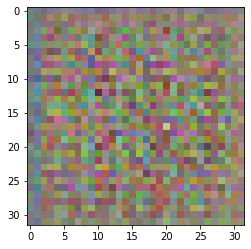

0it [00:00, ?it/s]
0it [00:00, ?it/s]

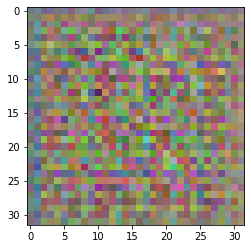

0it [00:00, ?it/s]
0it [00:00, ?it/s]

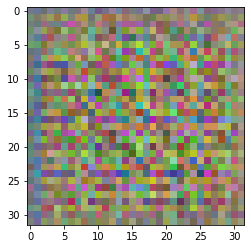

0it [00:00, ?it/s]
0it [00:00, ?it/s]

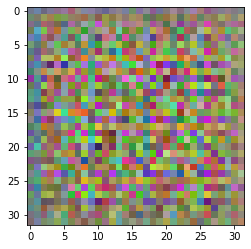

0it [00:00, ?it/s]
0it [00:00, ?it/s]

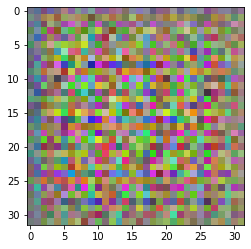

0it [00:00, ?it/s]
0it [00:00, ?it/s]

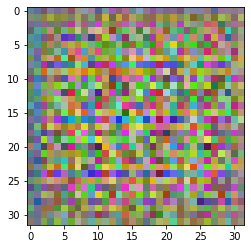

0it [00:00, ?it/s]
0it [00:00, ?it/s]

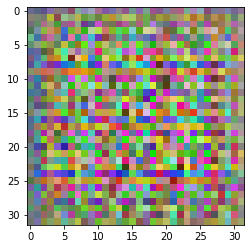

0it [00:00, ?it/s]
0it [00:00, ?it/s]

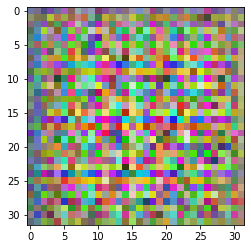

0it [00:00, ?it/s]
0it [00:00, ?it/s]

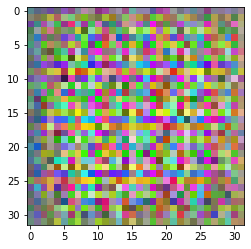

0it [00:00, ?it/s]
0it [00:00, ?it/s]

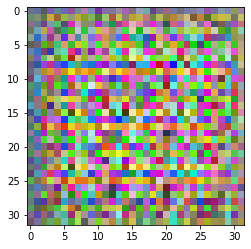

0it [00:00, ?it/s]
0it [00:00, ?it/s]

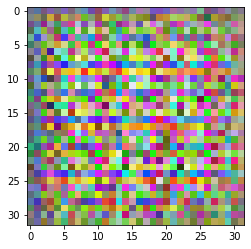

0it [00:00, ?it/s]
0it [00:00, ?it/s]

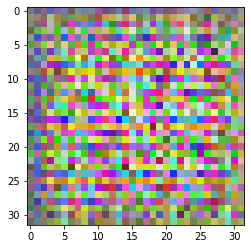

0it [00:00, ?it/s]
0it [00:00, ?it/s]

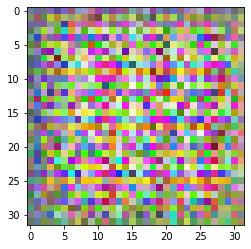

0it [00:00, ?it/s]
0it [00:00, ?it/s]

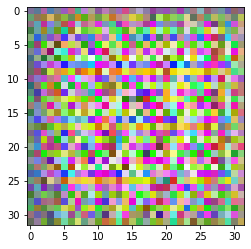

0it [00:00, ?it/s]
0it [00:00, ?it/s]

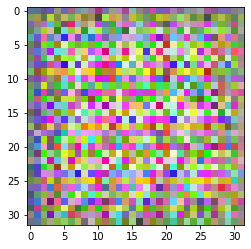

0it [00:00, ?it/s]
0it [00:00, ?it/s]

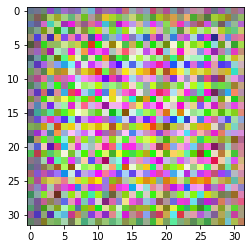

0it [00:00, ?it/s]
0it [00:00, ?it/s]

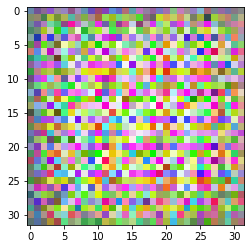

0it [00:00, ?it/s]
0it [00:00, ?it/s]

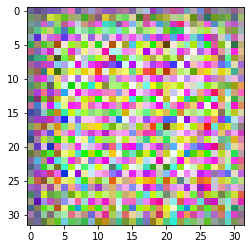

0it [00:00, ?it/s]
0it [00:00, ?it/s]

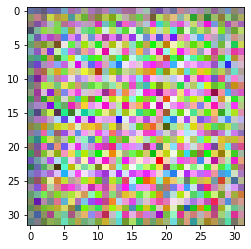

0it [00:00, ?it/s]
0it [00:00, ?it/s]

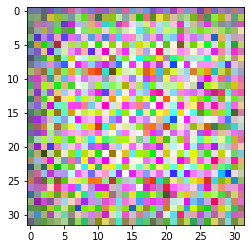

0it [00:00, ?it/s]
0it [00:00, ?it/s]

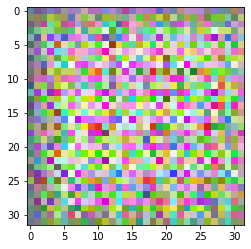

0it [00:00, ?it/s]
0it [00:00, ?it/s]

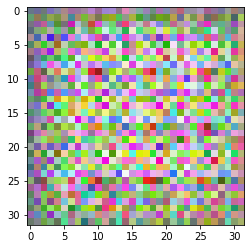

0it [00:00, ?it/s]
0it [00:00, ?it/s]

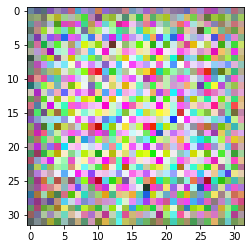

0it [00:00, ?it/s]
0it [00:00, ?it/s]

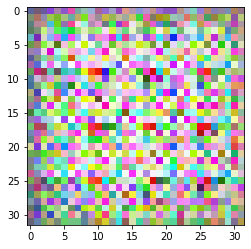

0it [00:00, ?it/s]
0it [00:00, ?it/s]

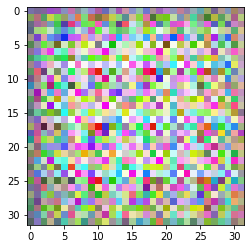

0it [00:01, ?it/s]
0it [00:00, ?it/s]

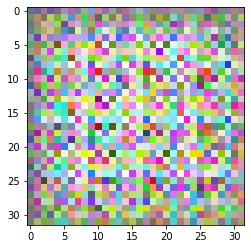

0it [00:00, ?it/s]
0it [00:00, ?it/s]

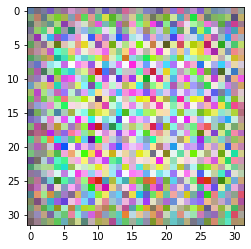

0it [00:00, ?it/s]
0it [00:00, ?it/s]

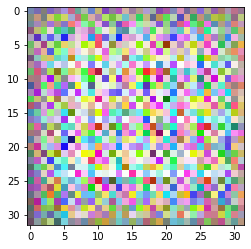

0it [00:00, ?it/s]
0it [00:00, ?it/s]

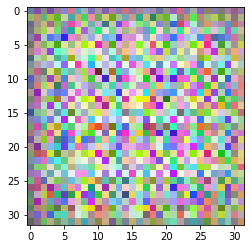

0it [00:00, ?it/s]
0it [00:00, ?it/s]

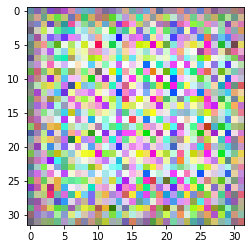

0it [00:00, ?it/s]
0it [00:00, ?it/s]

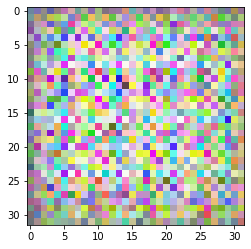

0it [00:00, ?it/s]
0it [00:00, ?it/s]

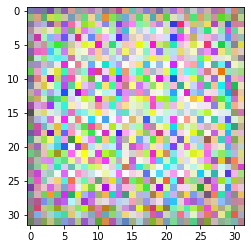

0it [00:00, ?it/s]
0it [00:00, ?it/s]

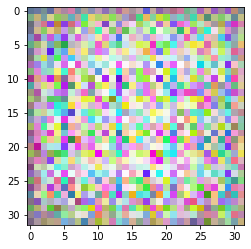

0it [00:00, ?it/s]
0it [00:00, ?it/s]

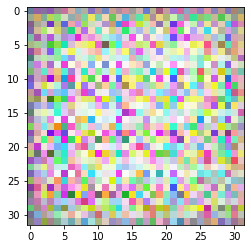

0it [00:00, ?it/s]
0it [00:00, ?it/s]

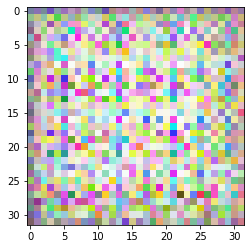

0it [00:00, ?it/s]
0it [00:00, ?it/s]

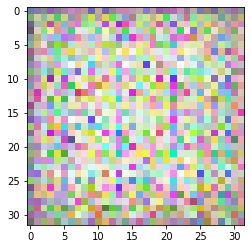

0it [00:00, ?it/s]
0it [00:00, ?it/s]

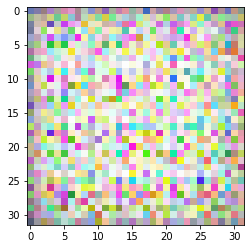

0it [00:00, ?it/s]
0it [00:00, ?it/s]

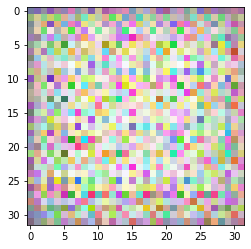

0it [00:00, ?it/s]
0it [00:00, ?it/s]

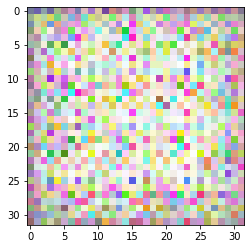

0it [00:00, ?it/s]
0it [00:00, ?it/s]


RuntimeError: Invalid argument: from_python argument must be an array.

In [132]:
for epoch in range(100):
    for i, (img_a, img_b) in tqdm(enumerate(train_dataloader)):
        img_a = shard(img_a.numpy())
        img_b = shard(img_b.numpy())

        rngs, variables_g, variables_d, optimizer_g, optimizer_d, d_loss, g_loss = train_step(
            rngs, variables_g, variables_d, optimizer_g, optimizer_d, img_a)

        if i % 10 == 0:
            to_log = {'g_loss': float(jnp.mean(g_loss)),
                        'd_loss': float(jnp.mean(d_loss))}
            if i % 500 == 0:
                rng, rng_sample = jax.random.split(rng)
                z = jax.random.normal(rng_sample, shape=(1, 1, 1, 100))

                temp_params_g = flax.jax_utils.unreplicate(optimizer_g.target)
                temp_variables_g = flax.jax_utils.unreplicate(variables_g)

                samples = Generator(training=False).apply({'params': temp_params_g, 'batch_stats': temp_variables_g['batch_stats']}, z, mutable=False)

                img = jnp.reshape((samples + 1) / 2, [32, 32, 3])
                # to_log['img'] = wandb.Image(np.array(img))
                img = np.array(img)
                plt.imshow(img)
                plt.show()
                break
            # wandb.log(to_log)